In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import isothermal_transmission
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities, plot_opacity_contributions, plot_planet_context

from petitRADTRANS.retrieval.models import (
    isothermal_transmission,
    guillot_transmission,
    guillot_patchy_transmission,
    madhu_seager_patchy_transmission
)
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

import os
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
multinest_path = os.path.abspath(os.path.join(os.getcwd(), "../../../MultiNest/lib"))
output_directory = os.path.join(root_path, "outputs")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = multinest_path
os.environ["LD_LIBRARY_PATH"] = multinest_path

# set_petitradtrans_plot_style()
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12 
%matplotlib inline

In [2]:
planet = Planet.get("K2-18 b")

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_isothermal_grey_clouds_simplified",
                                run_mode="retrieve",
                                pressures=np.logspace(-6, 2, 120))

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=isothermal_transmission,
    line_opacity_mode="c-k",
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=isothermal_transmission,
    line_opacity_mode="c-k"
)

retrieval_config.add_parameter('D_pl', False, value=planet.system_distance)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = planet.radius)
retrieval_config.add_parameter('mass', False, value = planet.mass)

retrieval_config.add_parameter('temperature', True, transform_prior_cube_coordinate = lambda x : 1000*x)
retrieval_config.add_parameter('log_Pcloud', True, transform_prior_cube_coordinate = lambda x: -6+7*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2'], eq=False, abund_lim = (-8.0,-0.1))

retrieval_config.parameters['temperature'].plot_in_corner = True
retrieval_config.parameters['temperature'].corner_ranges = (0,1000)
retrieval_config.parameters['log_Pcloud'].plot_in_corner = True
retrieval_config.parameters['log_Pcloud'].corner_ranges = (-6,1)
retrieval_config.parameters['patchiness'].plot_in_corner = True
retrieval_config.parameters['patchiness'].corner_ranges = (0,1)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRSPEC"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

retrieval1 = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      evaluate_sample_spectra=False,
                      use_prt_plot_style=True)

retrieval1.run(n_live_points=200,
              const_efficiency_mode=False,
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2

In [3]:
## Getting samples
sample_dict, parameter_dict = retrieval1.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval1.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval1.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval1.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths_iso, best_fit_spectrum_iso = retrieval1.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=isothermal_transmission,
            )

Best fit likelihood = 28831.66
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.c

Fetching for Nasa Exoplanet Archive Planetary Systems Composite Parameters Table...
Selecting planets...
 Selection statistics:
  - Planets in table: 5885
  - Planets in mass histogram: 5854
  - Planets in radius histogram: 5863
  - Planets in scatter plot: 668
Drawing plot...


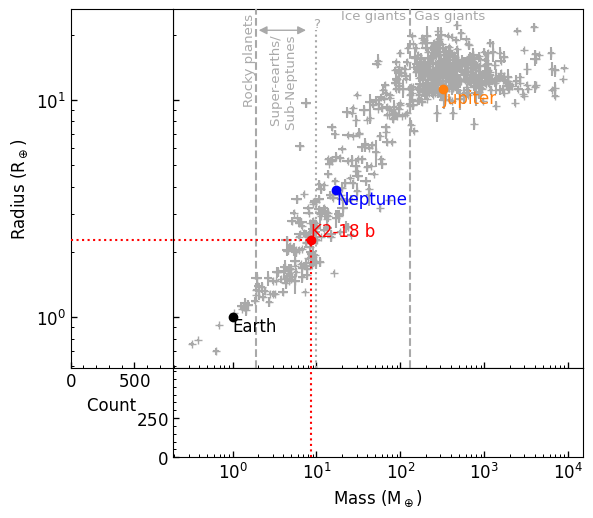

In [4]:
plot_planet_context("K2-18 b", tight_layout=False, save=True, figure_name='context')

In [5]:
planet = Planet.get("K2-18 b")

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_guillot_non_grey_clouds_simplified",
                                run_mode="evaluate",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('T_int', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('T_equ', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('gamma', True, transform_prior_cube_coordinate = lambda x : log_prior(x, -2, 1))
retrieval_config.add_parameter('log_kappa_IR', True, transform_prior_cube_coordinate = lambda x : -3+4*x)
retrieval_config.add_parameter('fsed_H2O(l)', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -3, 0))
retrieval_config.add_parameter('log_kzz', True, transform_prior_cube_coordinate = lambda x: 4+8*x)
retrieval_config.add_parameter('log_X_cb_H2O(l)', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('sigma_lnorm', True, transform_prior_cube_coordinate = lambda x: 1.05+1.95*x)
retrieval_config.add_parameter('log_Pbase_H2O(l)',  True, transform_prior_cube_coordinate = lambda x: -5+5*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2'], eq=False, abund_lim = (-8.0,-0.1))
retrieval_config.add_cloud_species('H2O(l)', eq=True)

retrieval_config.parameters['T_int'].plot_in_corner = True
retrieval_config.parameters['T_int'].corner_ranges = (0,600)
retrieval_config.parameters['T_equ'].plot_in_corner = True
retrieval_config.parameters['T_equ'].corner_ranges = (0,600)
retrieval_config.parameters['gamma'].plot_in_corner = True
retrieval_config.parameters['gamma'].corner_ranges = (-2,6)
retrieval_config.parameters['log_kappa_IR'].plot_in_corner = True
retrieval_config.parameters['log_kappa_IR'].corner_ranges = (-3,1)
retrieval_config.parameters['log_X_cb_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_X_cb_H2O(l)'].corner_ranges = (-6,0)
retrieval_config.parameters['fsed_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['fsed_H2O(l)'].corner_ranges = (0,1)
retrieval_config.parameters['sigma_lnorm'].plot_in_corner = True
retrieval_config.parameters['sigma_lnorm'].corner_ranges = (1.05,3)
retrieval_config.parameters['log_Pbase_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_Pbase_H2O(l)'].corner_ranges = (-5,2)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

retrieval2 = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval2.run(n_live_points=100,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbun

In [6]:
## Getting samples
sample_dict, parameter_dict = retrieval2.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval2.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval2.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval2.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths_gui, best_fit_spectrum_gui = retrieval2.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=guillot_transmission,
            )

Best fit likelihood = 28841.37
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.c

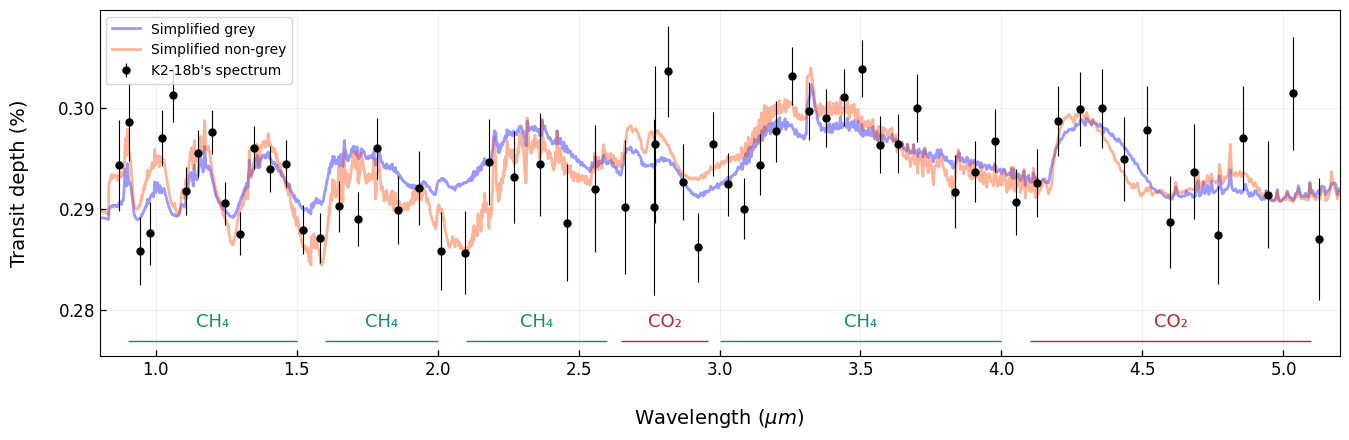

In [7]:
## Loading the low resolution spectra
niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), 
                     skiprows=1, names=["wl", "td", "td_e"], sep=r"\s", engine='python')
nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), 
                      skiprows=1, names=["wl", "td", "td_e"], sep=r"\s", engine='python')

features = {
    "CH₄": [(0.9, 1.5), (1.6, 2.0), (2.1, 2.6), (3.0, 4.0)],
    "CO₂": [(2.65, 2.96), (4.1, 5.1)],
}
y_feature = 0.277

## Binning the best fit model to spectra data
idx_niriss = []
idx_nirspec = []
for i in range(niriss["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths_iso-niriss["wl"][i])**2)
    idx_niriss.append(minIndex)
    
for j in range(nirspec["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths_iso-nirspec["wl"][j])**2)
    idx_nirspec.append(minIndex)

## Calculating the reduced chi squared
# chi2 = retrieval.get_reduced_chi2_from_model(best_fit_wavelengths_iso, best_fit_spectrum_iso, subtract_n_parameters = True)

## Plot of the best-fit spectra
ax = plt.figure(figsize=(16,4.5)).gca()
ax.plot(best_fit_wavelengths_iso, best_fit_spectrum_iso*100, 
        color="blue", alpha=0.4, linewidth=2, zorder=1, label="Simplified grey")
ax.plot(best_fit_wavelengths_gui, best_fit_spectrum_gui*100, 
        color="orangered", alpha=0.4, linewidth=2, zorder=1, label="Simplified non-grey")
# ax.plot(best_fit_wavelengths_iso[idx_niriss], best_fit_spectrum_iso[idx_niriss]*100, 'o',
#           color="orange", markeredgecolor="k", zorder=2, label="Data binned to spectra")
# ax.plot(best_fit_wavelengths_iso[idx_nirspec], best_fit_spectrum_iso[idx_nirspec]*100, 'o',
#           color="orange", markeredgecolor="k", zorder=2)
ax.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", 
            label="K2-18b's spectrum", zorder=3, c='k', markersize=5, elinewidth=0.8)
ax.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", 
            zorder=3, c='k', markersize=5, elinewidth=0.8)
ax.set(xlim=(0.8, 5.2),
       xticks=np.arange(1, 5.5, 0.5), 
       # ylim=(0.275, 0.315),
       yticks=[0.28, 0.29, 0.30, 0.31],
      )
# ax.set_title(f'Best fit spectra', pad = 15, fontsize=16)
ax.set_ylabel('Transit depth (%)', fontsize=14, labelpad=20)
ax.set_xlabel(r'Wavelength (${\mu m}$)', fontsize=14, labelpad=20)
ax.grid(alpha=0.2)
ax.legend(loc="upper left", fontsize=10)

for label, ranges in features.items():
    if label=='CH₄': 
        color='#118a7e'
    else:
        color='#bc2525'
    for r in ranges:
        ax.hlines(y=y_feature, xmin=r[0], xmax=r[1], colors=color, linestyles='solid', linewidth=1)
        ax.text((r[0] + r[1]) / 2, y_feature + 0.001, label, fontsize=13, ha='center', va='bottom', color=color)
plt.savefig('spectra.png')
plt.show()

In [7]:
## Calculating the forward best-fit model

parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'temperature': Parameter('temperature', False, value= retrieval1.best_fit_parameters['temperature'].value),
    'log_Pcloud': Parameter('log_Pcloud', False, value= retrieval1.best_fit_parameters['log_Pcloud'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval1.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= retrieval1.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval1.best_fit_parameters['CO2'].value),
}

line_species = [
    'CH4',
    'CO2',
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,120)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = isothermal_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = isothermal_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Do

In [8]:
from petitRADTRANS.chemistry.utils import mass_fractions2metallicity, compute_mean_molar_masses, mass_fractions2volume_mixing_ratios
from petitRADTRANS.chemistry.utils import compute_mean_molar_masses
from petitRADTRANS.chemistry.utils import mass_fractions2metallicity

mass_fractions = {
    'CH4': np.ones_like(pressures) * 10**retrieval1.best_fit_parameters['CH4'].value,
    'CO2': np.ones_like(pressures) * 10**retrieval1.best_fit_parameters['CO2'].value,
}

total_mass_fractions = np.sum(list(mass_fractions.values()), axis=0)
mass_fractions['H2'] = np.ones_like(pressures) * 0.6 * (1 - total_mass_fractions)
mass_fractions['He'] = np.ones_like(pressures) * 0.4 * (1 - total_mass_fractions)

vmrs = mass_fractions2volume_mixing_ratios(mass_fractions)


mean_molar_masses = compute_mean_molar_masses(mass_fractions)

metallicity, h_ratios = mass_fractions2metallicity(mass_fractions, mean_molar_masses)

print(f"Z = {np.mean(metallicity):.2f} solar")

for dictionary in h_ratios.values():
    print(f"{dictionary['description']} = {np.mean(dictionary['relative to solar']):.2f} solar")

Z = 0.78 solar
He/H = 1.98 solar
C/H = 2.27 solar
O/H = 0.58 solar


Generating temporary Radtrans object with 'line_species': 'CH4'
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO2'
Loading Radtrans opacities...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'

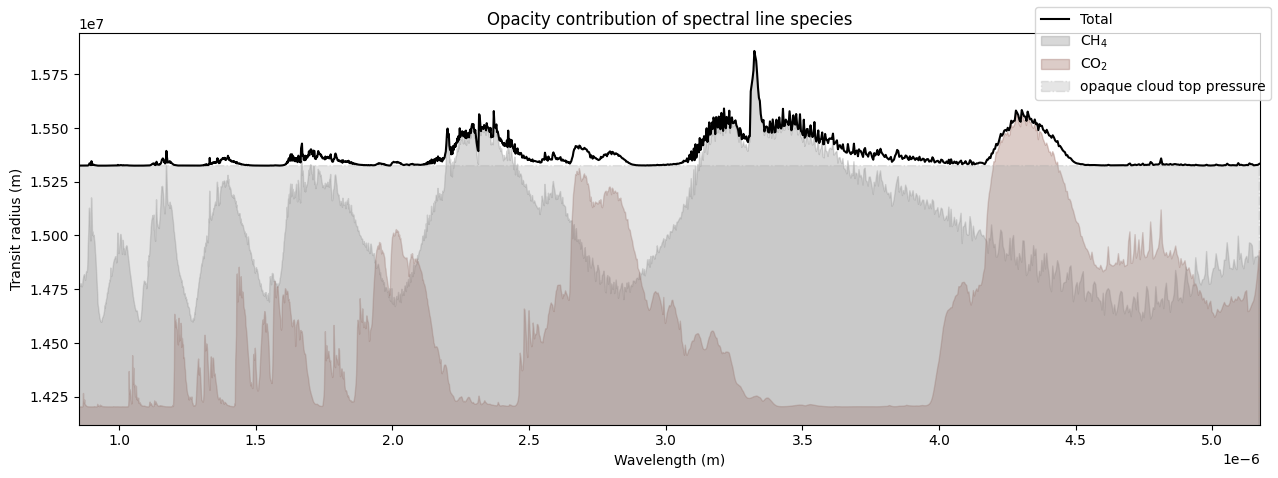

In [9]:
from petitRADTRANS.plotlib import plot_radtrans_opacities, plot_opacity_contributions


plot_opacity_contributions(atmosphere,
                           exclude=['He (Rayleigh)', 'H2 (Rayleigh)', 'H2--H2', 'H2--He'],
                           mode="transmission",
                           temperatures=temperature, 
                           mass_fractions=mass_fractions,
                           mean_molar_masses=compute_mean_molar_masses(mass_fractions),
                           reference_gravity=planet.reference_gravity,
                           reference_pressure=planet.reference_pressure,
                           planet_radius=0.211*cst.r_jup,
                           fill_below=True,
                           fill_alpha=0.3,
                           # gray_opacity=True,
                           opaque_cloud_top_pressure=1e-3,
                           # cloud_particles_mean_radii={'H2O(l)': 10**retrieval.best_fit_parameters['log_cloud_radius_H2O(l)'].value},
                           # eddy_diffusion_coefficients=np.ones_like(pressure)*retrieval.best_fit_parameters['log_kzz'].value,
                           # cloud_f_sed=retrieval.best_fit_parameters['fsed_H2O(l)'].value,
                           # cloud_particle_radius_distribution_std=retrieval.best_fit_parameters['sigma_lnorm'].value,
                          )
plt.title('Opacity contribution of spectral line species')
plt.show()

Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Do

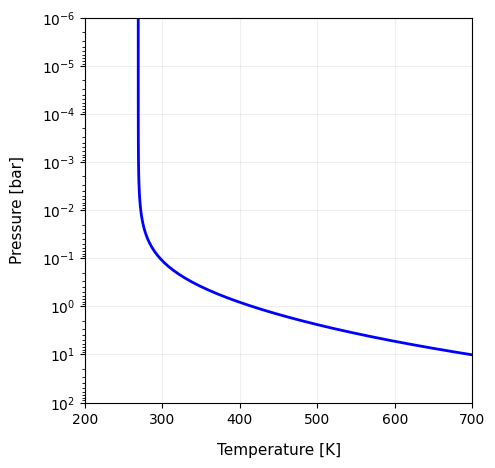

In [10]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= planet.radius),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),    
    'T_int': Parameter('T_int', False, value= retrieval2.best_fit_parameters['T_int'].value),
    'T_equ': Parameter('T_equ', False, value= retrieval2.best_fit_parameters['T_equ'].value),
    'gamma': Parameter('gamma', False, value= retrieval2.best_fit_parameters['gamma'].value),
    'log_kappa_IR': Parameter('log_kappa_IR', False, value= retrieval2.best_fit_parameters['log_kappa_IR'].value),
    'log_kzz': Parameter('log_kzz', False, value= retrieval2.best_fit_parameters['log_kzz'].value),
    'log_X_cb_H2O(l)': Parameter('log_X_cb_H2O(l)', False, value= retrieval2.best_fit_parameters['log_X_cb_H2O(l)'].value),
    'sigma_lnorm': Parameter('sigma_lnorm', False, value= retrieval2.best_fit_parameters['sigma_lnorm'].value),
    'log_Pbase_H2O(l)': Parameter('log_Pbase_H2O(l)', False, value= retrieval2.best_fit_parameters['log_Pbase_H2O(l)'].value),
    'fsed_H2O(l)': Parameter('fsed_H2O(l)', False, retrieval2.best_fit_parameters['fsed_H2O(l)'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval2.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= retrieval1.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval1.best_fit_parameters['CO2'].value),
}

line_species = [
    'CH4',
    'CO2',
]


rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = ['H2O(l)']
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model= guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(temperature, pressure, linewidth = 2, color='blue')
ax.set(
       xlim=(200, 700),
       ylim=(1e-6,1e2),
        yscale='log'
      )
# ax.text(250, 0.8, "1 atm", fontsize=10, alpha=0.4) 
ax.set_xlabel("Temperature [K]", fontsize=11, labelpad=12)
ax.set_ylabel(r"Pressure [bar]", fontsize=11, labelpad=12)
ax.invert_yaxis()

ax.grid(alpha=0.2)
plt.show()

In [11]:
from petitRADTRANS.chemistry.utils import mass_fractions2metallicity, compute_mean_molar_masses, mass_fractions2volume_mixing_ratios
from petitRADTRANS.chemistry.utils import compute_mean_molar_masses
from petitRADTRANS.chemistry.utils import mass_fractions2metallicity

mass_fractions = {
    'CH4': np.ones_like(pressures) * 10**retrieval2.best_fit_parameters['CH4'].value,
    'CO2': np.ones_like(pressures) * 10**retrieval2.best_fit_parameters['CO2'].value,
    'H2O(l)': np.ones_like(pressures) * 10**retrieval2.best_fit_parameters['log_X_cb_H2O(l)'].value
}

total_mass_fractions = np.sum(list(mass_fractions.values()), axis=0)
mass_fractions['H2'] = np.ones_like(pressures) * 0.6 * (1 - total_mass_fractions)
mass_fractions['He'] = np.ones_like(pressures) * 0.4 * (1 - total_mass_fractions)

vmrs = mass_fractions2volume_mixing_ratios(mass_fractions)


mean_molar_masses = compute_mean_molar_masses(mass_fractions)

metallicity, h_ratios = mass_fractions2metallicity(mass_fractions, mean_molar_masses)

print(f"Z = {np.mean(metallicity):.2f} solar")

for dictionary in h_ratios.values():
    print(f"{dictionary['description']} = {np.mean(dictionary['relative to solar']):.2f} solar")

Z = 13.71 solar
He/H = 1.90 solar
C/H = 17.68 solar
O/H = 22.09 solar


/Users/felipemustafa/Documents/interplay/petit/prt/lib/python3.13/site-packages/petitRADTRANS/chemistry/utils.py:603: UserWarning: the sum of volume mixing ratios at level 0 is not 1 (1.0172507700633073), results may be inaccurate
  warnings.warn(f"the sum of volume mixing ratios at level {i} is not 1 ({sum_vmr}), "
/Users/felipemustafa/Documents/interplay/petit/prt/lib/python3.13/site-packages/petitRADTRANS/chemistry/utils.py:603: UserWarning: the sum of volume mixing ratios at level 1 is not 1 (1.0172507700633073), results may be inaccurate
  warnings.warn(f"the sum of volume mixing ratios at level {i} is not 1 ({sum_vmr}), "
/Users/felipemustafa/Documents/interplay/petit/prt/lib/python3.13/site-packages/petitRADTRANS/chemistry/utils.py:603: UserWarning: the sum of volume mixing ratios at level 2 is not 1 (1.0172507700633073), results may be inaccurate
  warnings.warn(f"the sum of volume mixing ratios at level {i} is not 1 ({sum_vmr}), "
/Users/felipemustafa/Documents/interplay/petit

Generating temporary Radtrans object with 'line_species': 'CH4'
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO2'
Loading Radtrans opacities...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'

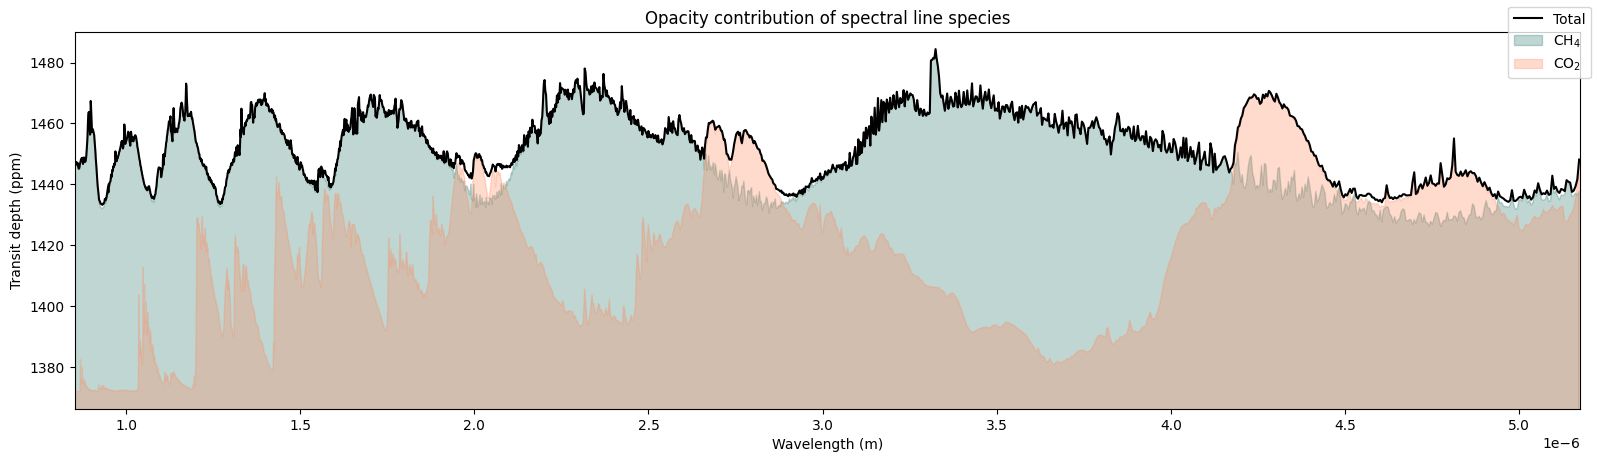

In [85]:
test = plot_opacity_contributions(atmosphere,
                           # exclude=['He (Rayleigh)', 'H2 (Rayleigh)', 'H2--H2', 'H2--He', 'H2O'],
                            include=['CH4', 'CO2', 'Total', 'H2O(l)'],
                           colors={
                                'Total': 'k', 
                                'line_species': {
                                    'H2O': 'aqua', 
                                    'CH4': '#2c786c',
                                    'CO2': '#ff895d',
                                }, 
                                'rayleigh_species': {
                                    'CH4': 'purple'
                                }
                                },
                           mode="transmission",
                            fig_size=(16,4.5),
                           temperatures=temperature, 
                           mass_fractions=mass_fractions,
                           mean_molar_masses=compute_mean_molar_masses(mass_fractions),
                           reference_gravity=planet.reference_gravity,
                           reference_pressure=planet.reference_pressure,
                           planet_radius=planet.radius,
                           fill_below=True,
                           fill_alpha=0.3,
                           # gray_opacity=True,
                           # opaque_cloud_top_pressure=-1,
                           # cloud_particles_mean_radii={'H2O(l)': 10**retrieval2.best_fit_parameters['log_cloud_radius_H2O(l)'].value},
                           eddy_diffusion_coefficients=np.ones_like(pressure)*retrieval2.best_fit_parameters['log_kzz'].value,
                           cloud_f_sed=retrieval2.best_fit_parameters['fsed_H2O(l)'].value,
                           cloud_particle_radius_distribution_std=retrieval2.best_fit_parameters['sigma_lnorm'].value,
                            star_radius=planet.star_radius
                          )
plt.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", 
            label="K2-18b's spectrum", zorder=3, c='k', markersize=20, elinewidth=0.8)
plt.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", 
            zorder=3, c='k', markersize=20, elinewidth=0.8)
plt.title('Opacity contribution of spectral line species')
plt.show()

In [32]:
dir(atmosphere)

['_Radtrans__absorber_present',
 '_Radtrans__check_anisotropic_cloud_scattering',
 '_Radtrans__check_input_data_file_existence',
 '_Radtrans__check_line_opacity_mode',
 '_Radtrans__check_path_input_data',
 '_Radtrans__check_pressures',
 '_Radtrans__check_return_clear_spectrum_relevance',
 '_Radtrans__check_wavelength_boundaries',
 '_Radtrans__clouds_have_effect',
 '_Radtrans__compute_additional_continuum_opacities',
 '_Radtrans__compute_cloud_continuum_opacities',
 '_Radtrans__compute_combined_opacities',
 '_Radtrans__compute_continuum_opacities',
 '_Radtrans__compute_continuum_scattering_opacities',
 '_Radtrans__dat_opacity_files_warning_message',
 '_Radtrans__get_base_opacities',
 '_Radtrans__get_base_species_mass_fractions',
 '_Radtrans__get_cia_contributors',
 '_Radtrans__get_frequency_grids_intersection_indices',
 '_Radtrans__get_line_opacity_file',
 '_Radtrans__get_non_cia_gas_continuum_contributions',
 '_Radtrans__get_opacity_sources_dict',
 '_Radtrans__init_clouds_particles_por

In [44]:
test=atmosphere.calculate_transit_radii(temperature, mass_fractions, compute_mean_molar_masses(mass_fractions), planet.reference_gravity,
                                   reference_pressure=planet.reference_pressure,
                           planet_radius=planet.radius,
                                   eddy_diffusion_coefficients=np.ones_like(pressure)*retrieval2.best_fit_parameters['log_kzz'].value,
                           cloud_f_sed=retrieval2.best_fit_parameters['fsed_H2O(l)'].value,
                           cloud_particle_radius_distribution_std=retrieval2.best_fit_parameters['sigma_lnorm'].value,
                                  return_opacities=True)

In [54]:
test[2]['opacities'].shape

(16, 1804, 2, 100)

In [71]:
test[2]['opacities'][0][100][0][:]*100

array([0.00087709, 0.00087709, 0.00087709, 0.00087709, 0.0008771 ,
       0.0008771 , 0.0008771 , 0.0008771 , 0.0008771 , 0.00087711,
       0.00087711, 0.00087711, 0.00087712, 0.00087716, 0.00087722,
       0.0008773 , 0.0008774 , 0.00087744, 0.00087741, 0.00087737,
       0.00087733, 0.00087733, 0.00087746, 0.0008776 , 0.00087778,
       0.00087796, 0.00087808, 0.00087821, 0.00087838, 0.0008786 ,
       0.00087899, 0.00087947, 0.00088004, 0.00088073, 0.00088155,
       0.00088255, 0.00088375, 0.0008852 , 0.00088698, 0.00088914,
       0.00089173, 0.00089486, 0.00089867, 0.00090329, 0.00090883,
       0.0009155 , 0.00092311, 0.00093198, 0.00094266, 0.0009555 ,
       0.00097088, 0.0009893 , 0.00101146, 0.00103812, 0.00106938,
       0.0011055 , 0.00114887, 0.00120092, 0.0012621 , 0.00133133,
       0.00141448, 0.00151437, 0.00163193, 0.0018108 , 0.00209039,
       0.00241311, 0.0027842 , 0.00316304, 0.00359835, 0.00409799,
       0.00467133, 0.00525031, 0.00589047, 0.00661094, 0.00827

In [72]:
pressures

array([1.00000000e-06, 1.20450354e-06, 1.45082878e-06, 1.74752840e-06,
       2.10490414e-06, 2.53536449e-06, 3.05385551e-06, 3.67837977e-06,
       4.43062146e-06, 5.33669923e-06, 6.42807312e-06, 7.74263683e-06,
       9.32603347e-06, 1.12332403e-05, 1.35304777e-05, 1.62975083e-05,
       1.96304065e-05, 2.36448941e-05, 2.84803587e-05, 3.43046929e-05,
       4.13201240e-05, 4.97702356e-05, 5.99484250e-05, 7.22080902e-05,
       8.69749003e-05, 1.04761575e-04, 1.26185688e-04, 1.51991108e-04,
       1.83073828e-04, 2.20513074e-04, 2.65608778e-04, 3.19926714e-04,
       3.85352859e-04, 4.64158883e-04, 5.59081018e-04, 6.73415066e-04,
       8.11130831e-04, 9.77009957e-04, 1.17681195e-03, 1.41747416e-03,
       1.70735265e-03, 2.05651231e-03, 2.47707636e-03, 2.98364724e-03,
       3.59381366e-03, 4.32876128e-03, 5.21400829e-03, 6.28029144e-03,
       7.56463328e-03, 9.11162756e-03, 1.09749877e-02, 1.32194115e-02,
       1.59228279e-02, 1.91791026e-02, 2.31012970e-02, 2.78255940e-02,
      

In [75]:
pressures

array([1.00000000e-06, 1.20450354e-06, 1.45082878e-06, 1.74752840e-06,
       2.10490414e-06, 2.53536449e-06, 3.05385551e-06, 3.67837977e-06,
       4.43062146e-06, 5.33669923e-06, 6.42807312e-06, 7.74263683e-06,
       9.32603347e-06, 1.12332403e-05, 1.35304777e-05, 1.62975083e-05,
       1.96304065e-05, 2.36448941e-05, 2.84803587e-05, 3.43046929e-05,
       4.13201240e-05, 4.97702356e-05, 5.99484250e-05, 7.22080902e-05,
       8.69749003e-05, 1.04761575e-04, 1.26185688e-04, 1.51991108e-04,
       1.83073828e-04, 2.20513074e-04, 2.65608778e-04, 3.19926714e-04,
       3.85352859e-04, 4.64158883e-04, 5.59081018e-04, 6.73415066e-04,
       8.11130831e-04, 9.77009957e-04, 1.17681195e-03, 1.41747416e-03,
       1.70735265e-03, 2.05651231e-03, 2.47707636e-03, 2.98364724e-03,
       3.59381366e-03, 4.32876128e-03, 5.21400829e-03, 6.28029144e-03,
       7.56463328e-03, 9.11162756e-03, 1.09749877e-02, 1.32194115e-02,
       1.59228279e-02, 1.91791026e-02, 2.31012970e-02, 2.78255940e-02,
      

In [ ]:
wavelengths, flux, additional_outputs = atmosphere.calculate_transit_radii(
    temperatures=temperature,
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=planet.reference_gravity,
    reference_pressure=100,
    planet_radius=0.211*cst.r_jup,
    eddy_diffusion_coefficients=np.ones_like(pressure)*retrieval2.best_fit_parameters['log_kzz'].value,
    cloud_f_sed=retrieval2.best_fit_parameters['fsed_H2O(l)'].value,
    cloud_particle_radius_distribution_std=retrieval2.best_fit_parameters['sigma_lnorm'].value,
    cloud_fraction=retrieval2.best_fit_parameters['patchiness'].value,
    return_opacities=True,
)

# x, y = np.meshgrid(wavelength, pressures)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.contourf(x, y, additional_outputs['transmission_contribution'], 30, cmap=plt.cm.bone_r)

# # ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_ylim([1e2, 1e-6])
# ax.set_xlim([wavelength[0], wavelength[-1]])

# ax.set_xlabel('Wavelength [micron]')
# ax.set_ylabel('Pressure [bar]')
# ax.set_title('Transmission contribution function')


In [ ]:
additional_outputs['opacities'].shape